In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [2]:
import os
import pandas as pd

MildDemented_dir = r'/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset/MildDemented'
ModerateDemented_dir = r'/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset/ModerateDemented'
NonDemented_dir = r'/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset/NonDemented'
VeryMildDemented_dir = r'/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset/VeryMildDemented'

In [3]:
import os
import pandas as pd
import numpy as np
import warnings
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from tensorflow.keras.optimizers import Adamax
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from PIL import Image
from tensorflow.keras.callbacks import ReduceLROnPlateau
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
from rich import print
import time

warnings.filterwarnings(action="ignore")


ep = 10
bs = 32

timing_results = []


def record_time(stage_name, start_time, end_time):
    elapsed_time = end_time - start_time
    timing_results.append({"Stage": stage_name, "Time (s)": elapsed_time})
    print(f"{stage_name} completed in {elapsed_time:.2f} seconds.")




In [4]:

# MildDemented_dir = "/Volumes/JasonT7/2.Education/Research/Thesis/Paper/0017. alzheimerPrediction/data2/external/MildDemented"
# ModerateDemented_dir = "/Volumes/JasonT7/2.Education/Research/Thesis/Paper/0017. alzheimerPrediction/data2/external/ModerateDemented"
# NonDemented_dir = "/Volumes/JasonT7/2.Education/Research/Thesis/Paper/0017. alzheimerPrediction/data2/external/NonDemented"
# VeryMildDemented_dir = "/Volumes/JasonT7/2.Education/Research/Thesis/Paper/0017. alzheimerPrediction/data2/external/VeryMildDemented"

filepaths, labels = [], []
cls_lbl = [
    "Mild Demented",
    "Moderate Demented",
    "Non Demented",
    "Very MildDemented",
]
dict_list = [
    MildDemented_dir,
    ModerateDemented_dir,
    NonDemented_dir,
    VeryMildDemented_dir,
]

for i, j in enumerate(dict_list):
    flist = os.listdir(j)
    for f in flist:
        fpath = os.path.join(j, f)
        filepaths.append(fpath)
        labels.append(cls_lbl[i])

start_time = time.time()

valid_filepaths, valid_labels = [], []
for filepath, label in zip(filepaths, labels):
    try:
        with Image.open(filepath) as img:
            img.verify()
            valid_filepaths.append(filepath)
            valid_labels.append(label)
    except (IOError, SyntaxError):
        print(f"Corrupted image file: {filepath}")

data_df = pd.DataFrame({"filepaths": valid_filepaths, "labels": valid_labels})
end_time = time.time()
record_time("Data Loading and Preprocessing", start_time, end_time)
print(data_df["labels"].value_counts())


Data Loading and Preprocessing completed in 19.20 seconds.

labels
Non Demented         9600
Mild Demented        8960
Very MildDemented    8960
Moderate Demented    6464
Name: count, dtype: int64

In [5]:

from sklearn.model_selection import train_test_split

train_set, test_images = train_test_split(data_df, test_size=0.3, random_state=42)
val_set, test_images = train_test_split(test_images, test_size=0.5, random_state=42)

image_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train = image_gen.flow_from_dataframe(
    train_set,
    x_col="filepaths",
    y_col="labels",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=bs,
    shuffle=False,
)

val = image_gen.flow_from_dataframe(
    val_set,
    x_col="filepaths",
    y_col="labels",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=bs,
    shuffle=False,
)

test = image_gen.flow_from_dataframe(
    test_images,
    x_col="filepaths",
    y_col="labels",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=bs,
    shuffle=False,
)

print(f"Train images:{len(train_set)}")
print(f"Val images:{len(val_set)}")
print(f"Test images:{len(test_images)}")




Found 23788 validated image filenames belonging to 4 classes.
Found 5098 validated image filenames belonging to 4 classes.
Found 5098 validated image filenames belonging to 4 classes.


Train images:23788

Val images:5098

Test images:5098

In [6]:
start_time = time.time()

base_model = EfficientNetB0(
    include_top=False, weights="imagenet", input_shape=(224, 224, 3), pooling="avg"
)

model = Sequential(
    [
        base_model,
        Flatten(),
        Dense(128, activation="relu"),
        Dropout(0.3),
        Dense(4, activation="softmax"),
    ]
)

model.compile(
    optimizer=Adamax(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

early_stopping = EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)
end_time = time.time()
record_time("Model Building", start_time, end_time)


Model Building completed in 2.02 seconds.

In [7]:

model.summary()


start_time = time.time()
history = model.fit(
    train, epochs=ep, validation_data=val, callbacks=[early_stopping, reduce_lr]
)
end_time = time.time()
record_time("Model Training", start_time, end_time)

# model = tf.keras.models.load_model(
#     f"/Volumes/JasonT7/2.Education/Research/Thesis/Paper/0017. alzheimerPrediction/models/jason_alzheimer_prediction_model_{len(train_set)}_images_{ep}_epochs.keras"
# )

start_time = time.time()
test_loss, test_accuracy = model.evaluate(test)
end_time = time.time()
record_time("Model Evaluation", start_time, end_time)
print(f"Test Accuracy: {test_accuracy}")


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ ?                      │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 4,007,548 (15.29 MB)

 Non-trainable params: 42,023 (164.16 KB)

Epoch 1/10


I0000 00:00:1734728131.724671     302 service.cc:145] XLA service 0x7b2768003bc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734728131.724719     302 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734728131.724723     302 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1734728179.235674     302 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


744/744 ━━━━━━━━━━━━━━━━━━━━ 252s 237ms/step - accuracy: 0.6564 - loss: 0.7479 - val_accuracy: 0.9051 - val_loss: 0.2366 - learning_rate: 0.0010
Epoch 2/10
744/744 ━━━━━━━━━━━━━━━━━━━━ 126s 168ms/step - accuracy: 0.9454 - loss: 0.1455 - val_accuracy: 0.9645 - val_loss: 0.0943 - learning_rate: 0.0010
Epoch 3/10
744/744 ━━━━━━━━━━━━━━━━━━━━ 124s 167ms/step - accuracy: 0.9841 - loss: 0.0493 - val_accuracy: 0.9849 - val_loss: 0.0451 - learning_rate: 0.0010
Epoch 4/10
744/744 ━━━━━━━━━━━━━━━━━━━━ 124s 166ms/step - accuracy: 0.9910 - loss: 0.0273 - val_accuracy: 0.9737 - val_loss: 0.0900 - learning_rate: 0.0010
Epoch 5/10
744/744 ━━━━━━━━━━━━━━━━━━━━ 125s 167ms/step - accuracy: 0.9911 - loss: 0.0239 - val_accuracy: 0.9892 - val_loss: 0.0355 - learning_rate: 0.0010
Epoch 6/10
744/744 ━━━━━━━━━━━━━━━━━━━━ 123s 165ms/step - accuracy: 0.9931 - loss: 0.0189 - val_accuracy: 0.9898 - val_loss: 0.0323 - learning_rate: 0.0010
Epoch 7/10
744/744 ━━━━━━━━━━━━━━━━━━━━ 124s 166ms/step - accuracy: 0.9944 

Model Training completed in 1373.17 seconds.

160/160 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.9966 - loss: 0.0099


Model Evaluation completed in 8.27 seconds.

Test Accuracy: 0.9954884052276611

In [8]:

num_train_images = len(train_set)
model_save_path = f"jason_alzheimer_prediction_model_{len(train_set)}_images_{ep}_epochs.keras"
model.save(model_save_path)
print("Model saved successfully.")


# model = tf.keras.models.load_model(
#     f"/Volumes/JasonT7/2.Education/Research/Thesis/Paper/0017. alzheimerPrediction/models/jason_alzheimer_prediction_model_{len(train_set)}_images_{ep}_epochs.keras"
# )

from tqdm import tqdm
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    confusion_matrix,
)
import seaborn as sns
import matplotlib.pyplot as plt


def predict_with_uncertainty(model, dataset, n_samples=50):
    predictions = []
    total_batches = len(dataset)
    pbar_outer = tqdm(total=n_samples, desc="Monte Carlo Sampling", dynamic_ncols=True)

    for sample_idx in range(n_samples):
        batch_preds = []
        dataset.reset()
        pbar_inner = tqdm(
            total=total_batches,
            position=1,
            leave=False,
            desc=f"Processing Sample {sample_idx + 1}/{n_samples}",
            ncols=80,
        )

        for batch_idx, (images, _) in enumerate(dataset):
            if batch_idx >= total_batches:
                break
            preds = model(images, training=True)
            batch_preds.append(preds.numpy())
            pbar_inner.update(1)
        pbar_inner.close()
        predictions.append(np.vstack(batch_preds))
        pbar_outer.update(1)
    pbar_outer.close()
    predictions = np.stack(predictions, axis=0)
    mean_preds = np.mean(predictions, axis=0)
    uncertainty = np.std(predictions, axis=0)

    return mean_preds, uncertainty


start_time = time.time()
mean_predictions, uncertainty = predict_with_uncertainty(model, test, n_samples=5)
end_time = time.time()
record_time("Prediction", start_time, end_time)


Model saved successfully.

Monte Carlo Sampling: 100%|██████████| 5/5 [05:02<00:00, 60.56s/it]             


Prediction completed in 302.79 seconds.

Classification Metrics by Class:

,precision,recall,f1-score,accuracy
Mild Demented,0.99,1.00,1.00,1.00
Moderate Demented,1.00,1.00,1.00,1.00
Non Demented,0.99,0.99,0.99,0.99
Very MildDemented,0.99,0.99,0.99,0.99
macro avg,0.99,0.99,0.99,0.99
weighted avg,0.99,0.99,0.99,0.99


No. high-uncertainty pred where (uncertainty > 0.2): [ 58   1 101 113]

Monte Carlo Sampling: 100%|██████████| 10/10 [10:11<00:00, 61.15s/it]           


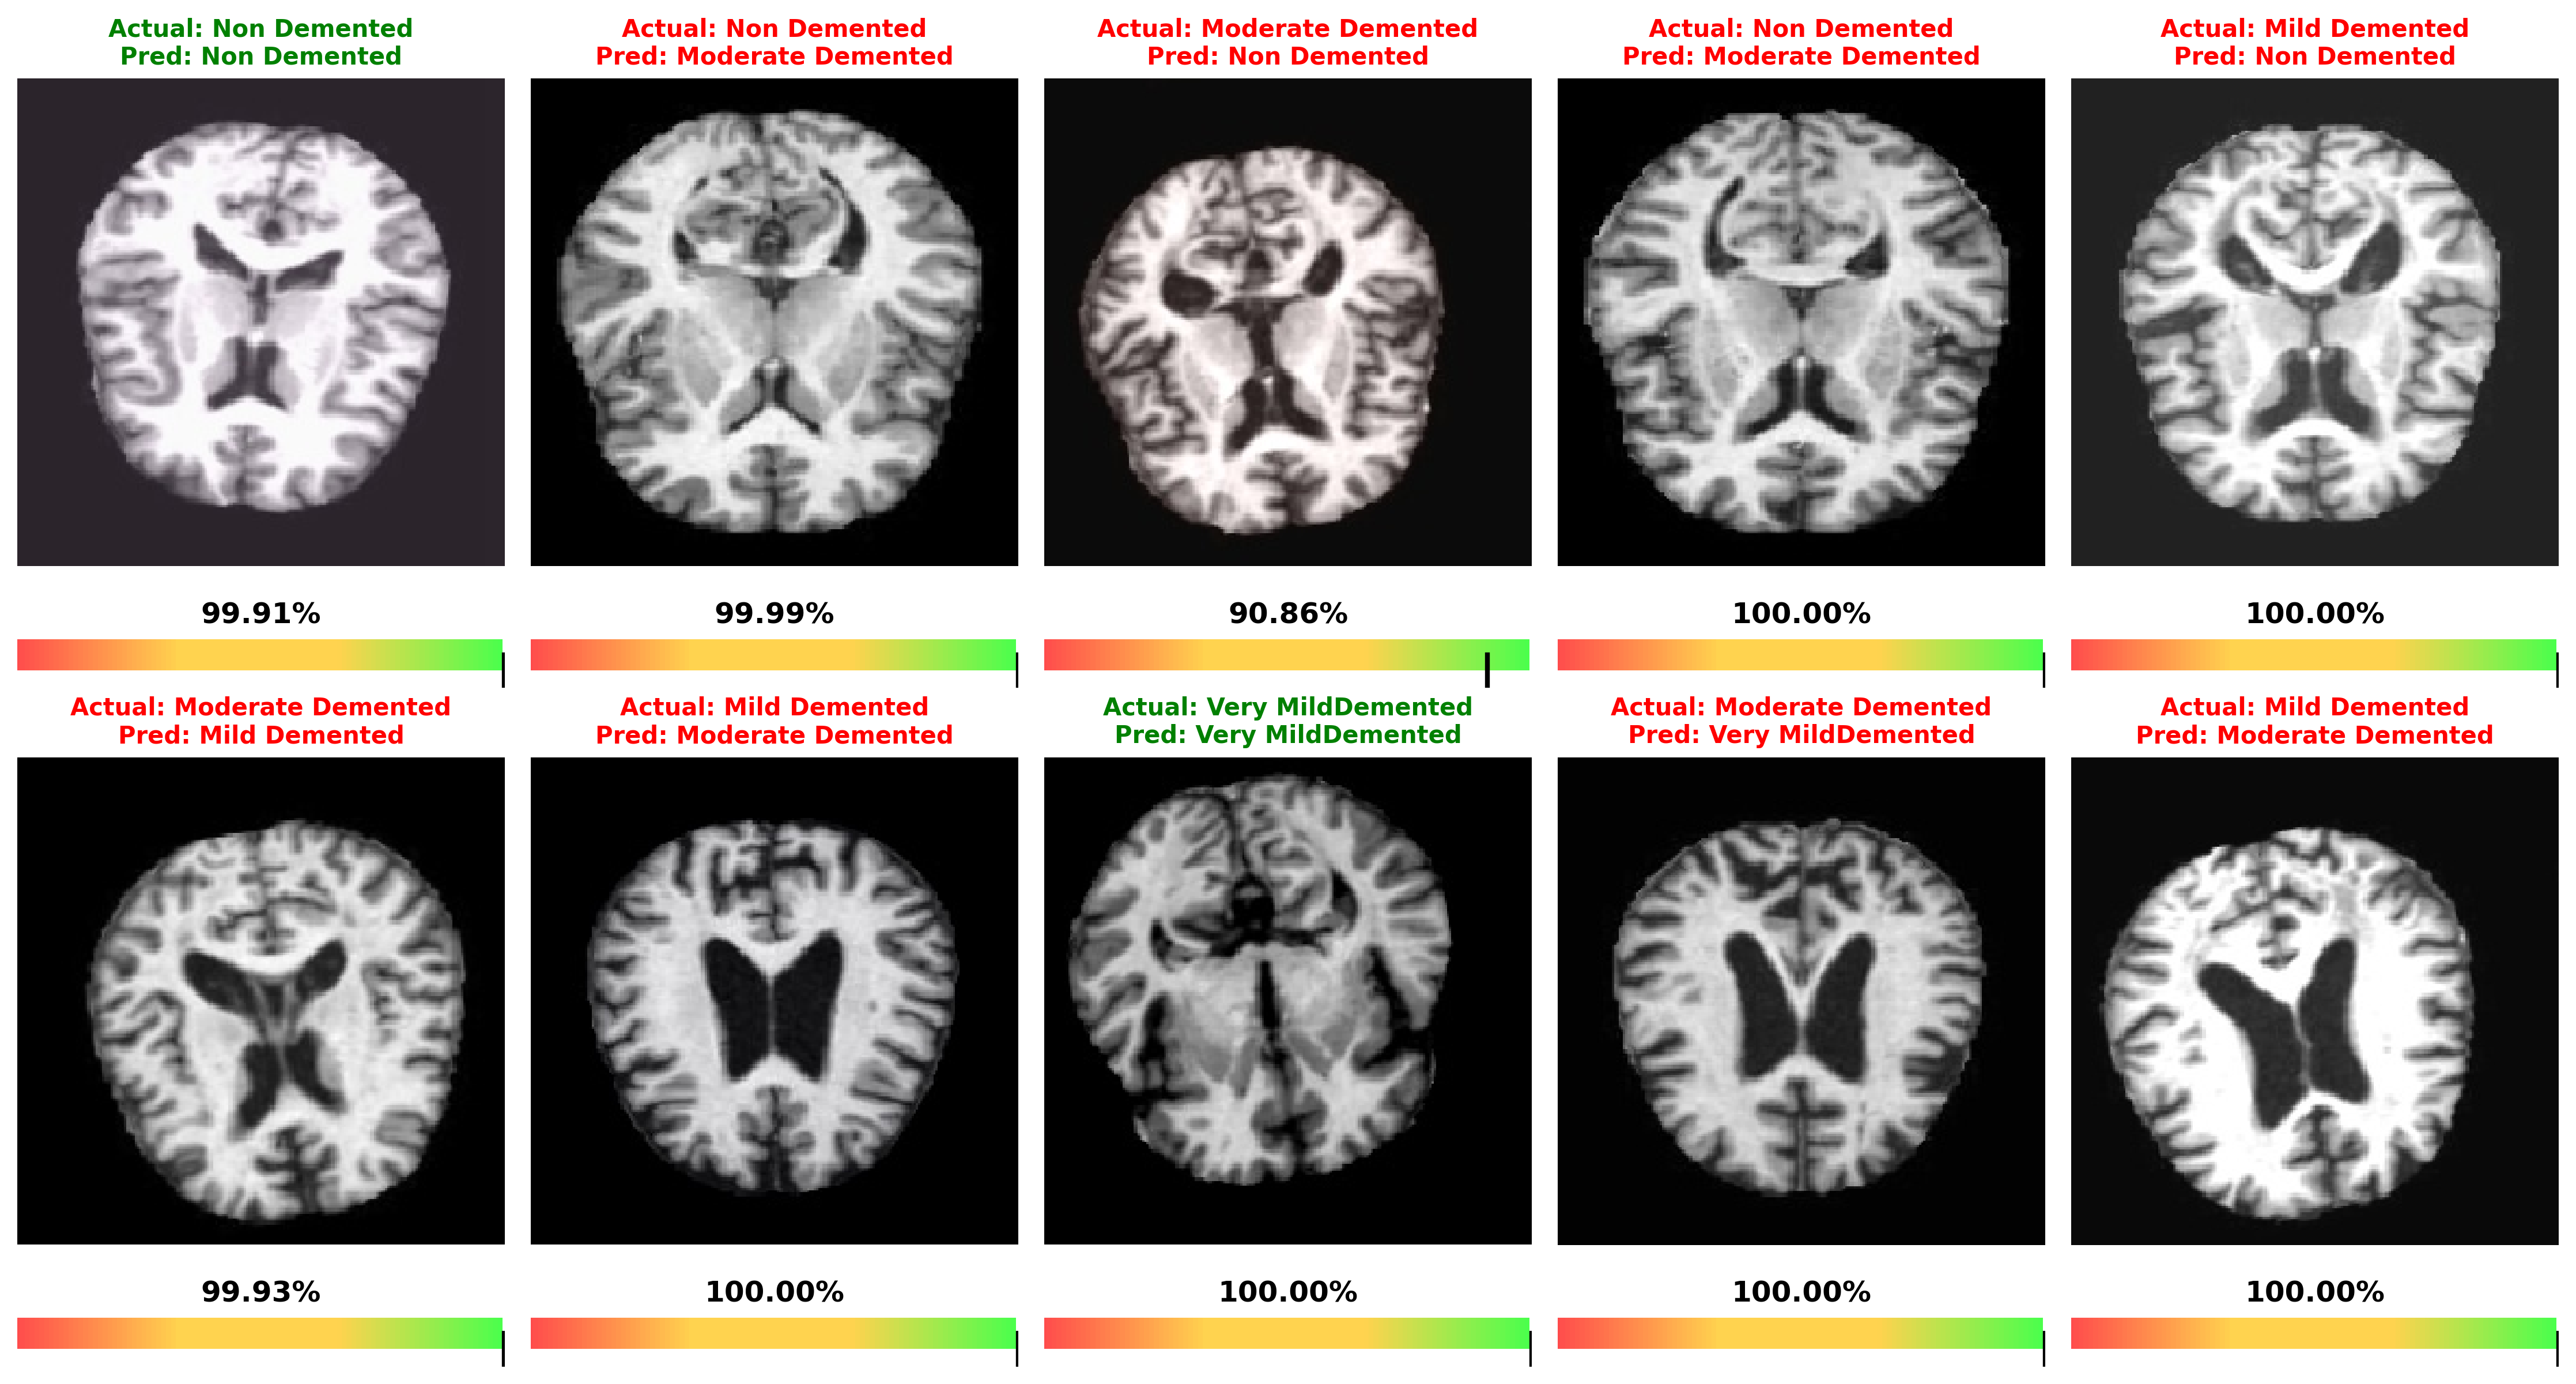

Timing Results for Each Stage

Stage     Time (s)
0  Data Loading and Preprocessing    19.202696
1                  Model Building     2.024389
2                  Model Training  1373.169747
3                Model Evaluation     8.265205
4                      Prediction   302.785877

<Figure size 640x480 with 0 Axes>

In [9]:

y_true = test.classes
y_true = np.array(y_true)
y_pred = np.argmax(mean_predictions, axis=1)

cls_ct = np.bincount(y_true)
cls_wt = cls_ct / len(y_true)

report = classification_report(
    y_true, y_pred, target_names=cls_lbl, output_dict=True
)

m_df = pd.DataFrame()

for no, cls in enumerate(cls_lbl):
    m_df.loc[cls, "precision"] = report[cls]["precision"]
    m_df.loc[cls, "recall"] = report[cls]["recall"]
    m_df.loc[cls, "f1-score"] = report[cls]["f1-score"]

    cls_msk = y_true == no
    class_accuracy = np.mean(y_pred[cls_msk] == y_true[cls_msk])
    m_df.loc[cls, "accuracy"] = class_accuracy

m_df.loc["macro avg", "precision"] = m_df.loc[
    cls_lbl, "precision"
].mean()
m_df.loc["macro avg", "recall"] = m_df.loc[cls_lbl, "recall"].mean()
m_df.loc["macro avg", "f1-score"] = m_df.loc[
    cls_lbl, "f1-score"
].mean()
m_df.loc["macro avg", "accuracy"] = m_df.loc[
    cls_lbl, "accuracy"
].mean()

m_df.loc["weighted avg", "precision"] = np.average(
    m_df.loc[cls_lbl, "precision"], weights=cls_wt
)
m_df.loc["weighted avg", "recall"] = np.average(
    m_df.loc[cls_lbl, "recall"], weights=cls_wt
)
m_df.loc["weighted avg", "f1-score"] = np.average(
    m_df.loc[cls_lbl, "f1-score"], weights=cls_wt
)
m_df.loc["weighted avg", "accuracy"] = np.average(
    m_df.loc[cls_lbl, "accuracy"], weights=cls_wt
)

m_df = m_df.round(2)

print("\nClassification Metrics by Class:")
display(m_df)

threshold = 0.2
high_uncertainty_count = sum(u > threshold for u in uncertainty)
print(
    f"No. high-uncertainty pred where (uncertainty > {threshold}): {high_uncertainty_count}"
)

sample_images, sample_labels = next(test)
sample_images = sample_images[:10]
mean_preds, uncertainty = predict_with_uncertainty(model, test, n_samples=10)
predicted_labels = np.argmax(mean_preds, axis=1)
actual_labels = sample_labels[:10]
actual_labels_indices = np.argmax(actual_labels, axis=1)


def visualize_predictions_with_uncertainty(
    images, actual_labels, predicted_labels, uncertainty, class_labels
):
    fig, axes = plt.subplots(2, 5, figsize=(15, 8), dpi=300)
    plt.subplots_adjust(hspace=0.5, wspace=0.2)

    for i in range(10):
        ax_img = axes[i // 5, i % 5]
        ax_bar = ax_img.inset_axes([0.0, -0.25, 1.0, 0.1])

        img = images[i]
        img = np.clip(img, 0, 255).astype(np.uint8)
        ax_img.imshow(img)
        ax_img.axis("off")

        actual_label = class_labels[actual_labels[i]]
        predicted_label = class_labels[predicted_labels[i]]

        # Calculate uncertainty and confidence
        if isinstance(uncertainty[i], np.ndarray):
            uncertainty_value = uncertainty[i].flatten()[0]
        else:
            uncertainty_value = uncertainty[i]
        confidence = 1 - uncertainty_value

        title_color = "green" if actual_labels[i] == predicted_labels[i] else "red"
        ax_img.set_title(
            f"Actual: {actual_label}\nPred: {predicted_label}",
            fontsize=10,
            loc="center",
            color=title_color,
            fontweight="bold",
        )
        colors = ["#FF4C4C", "#FFD34F", "#4CFF4C"]
        cmap = mcolors.LinearSegmentedColormap.from_list(
            "custom_gradient", ["#FF4C4C", "#FFD34F", "#FFD34F", "#4CFF4C"], N=100
        )
        ax_bar.imshow(np.linspace(0, 1, 100).reshape(1, -1), aspect="auto", cmap=cmap)
        ax_bar.plot([confidence * 100, confidence * 100], [0, 1], color="black", lw=2)
        ax_img.text(
            0.5,
            -0.1,
            f"{confidence * 100:.2f}%",
            ha="center",
            va="center",
            color="black",
            fontsize=12,
            fontweight="bold",
            transform=ax_img.transAxes,
        )

        ax_bar.set_xlim(0, 100)
        ax_bar.axis("off")
    plt.tight_layout()
    plt.show()
    plt.savefig(
        "predictions_with_uncertainty.png",
        dpi=300,
        bbox_inches="tight",
    )


visualize_predictions_with_uncertainty(
    sample_images,
    actual_labels_indices,
    predicted_labels,
    uncertainty[:10],
    cls_lbl,
)


import pandas as pd

timing_df = pd.DataFrame(timing_results)
print("\n[bold green]Timing Results for Each Stage[/bold green]")
print(timing_df)

timing_df.to_csv("timing_results.csv", index=False)

In [10]:
model.save(f"jason_alzheimer_prediction_model_{num_train_images}_images_{ep}_epochs.keras")